# Monte Carlo simulator

### Problem statement

Robot cars have a top speed (which they prefer to maintain at all times while driving) that’s a real number randomly drawn uniformly between 1 and 2 miles per minute. A two-lane highway for robot cars has a fast lane (with minimum speed a) and a slow lane (with maximum speed a). When a faster car overtakes a slower car in the same lane, the slower car is required to decelerate to either change lanes (if both cars start in the fast lane) or stop on the shoulder (if both cars start in the slow lane). Robot cars decelerate and accelerate at a constant rate of 1 mile per minute per minute, timed so the faster, overtaking car doesn’t have to change speed at all, and passing happens instantaneously. If cars rarely meet (so you never have to consider a car meeting more than one other car on its trip), and you want to minimize the miles not driven due to passing, what should a be set to, in miles per minute? Give your answer to 10 decimal places.

Example car interactions: suppose a is set to 1.2 miles per minute. If a car with top speed 1.8 overtakes a car with top speed 1.1, neither has to slow down because they are in different lanes. If instead the car with top speed 1.8 overtakes one with top speed 1.7, the slower car computes the optimal time to start decelerating for 30 seconds (to reach 1.2 miles per minute to switch to the other lane) so the faster car instantly passes and the slower car can immediately start accelerating for another 30 seconds to return to 1.7 miles per minute. This pass cost 0.25 miles (how far behind where the slower car would be if it continued at 1.7 miles per minute).

If a car with top speed 1.1 overtakes one with top speed 1.0 in the slow lane, the slower (slowest!) car must decelerate for a full minute all the way to 0 to allow the pass, and then accelerate for a full minute to reestablish its speed, losing exactly 1 mile of distance.

Assume all car trips are of constant length N, starting at arbitrary points and times along an infinitely long highway.

### Approach

Note that if there are no interactions between cars, any a is optimal, as cars lose no time. The problem statement says to only consider cases of one interaction.

We must use physics principles to approach this problem. First, we perform a Galilean shift $ v \rarr v - 1$, getting the following new constraints:

$$v1, v2 \in [0,1]$$
$$a \in [0,1]$$
Cars must slow down to speed -1 to stop.<br><br>

Which are easier to deal with. Now, we can compute the number of miles lost as a function of $v_1, v_2, a$. Without loss of generality, assume $v_1 > v_2$. We ignore cases where $v_1 = v_2$ or $v_1 = a$ or $v_2 = a$, which have measure 0.

Case 1: $a > v_1 > v_2$: Both cars in the slow lane, so the slower car must slow down from $v_2$ to $-1$. This costs $(v_2+1)^2$ miles.
Case 2: $v_1 > a > v_2$: Cars are in separate lanes. 0 miles lost.
Case 3: $v_1 > v_2 > a$: Both cars are in the fast lane, so the slower car must slow down to $a$. This costs $(v_2-a)^2$ miles.


Since the cost function is piecewise, we can use monte-carlo methods to check our work.


In [20]:
import numpy as np
import numpy as np

N= 100000  # Number of random samples
v1 = np.random.uniform(0, 1, N)
v2 = np.random.uniform(0, 1, N)

# Sort so that v1 < v2
vmin = np.minimum(v1, v2)
vmax = np.maximum(v1, v2)

# Use the same common random numbers to reduce variance

def simulate_cost_vectorized(a):


    # Case 1: a > vmax → slow down to speed a
    case1 = a > vmax
    cost1 = (vmin[case1] - a) ** 2

    # Case 2: vmin <= a <= vmax → no change
    case2 = (a >= vmin) & (a <= vmax)
    cost2 = np.zeros(np.sum(case2))

    # Case 3: a < vmin → slow down to -1
    case3 = a < vmin
    cost3 = (vmin[case3] + 1) ** 2

    all_costs = np.concatenate([cost1, cost2, cost3])
    return np.mean(all_costs)


def optimize(a):
    # Use a binary search to find the optimal value of a
    # Note that this assumes E(a) is a convex function
    # Based on the mathematical analysis, we can guess that E(a) is in fact a convex function
    low, high = 0, 1
    epsilon = 1e-3
    while high - low > epsilon:
        mid = (low + high) / 2
        cost_mid = simulate_cost_vectorized(mid)
        cost_low = simulate_cost_vectorized(low)
        if cost_mid < cost_low:
            low = mid
        else:
            high = mid
        print(f"low: {low}, high: {high}, mid: {mid}, cost_mid: {cost_mid}, cost_low: {cost_low}")


optimize(0.5)

low: 0.5, high: 1, mid: 0.5, cost_mid: 0.7344760483748695, cost_low: 1.8360944198029605
low: 0.75, high: 1, mid: 0.75, cost_mid: 0.3700045885186158, cost_low: 0.7344760483748695
low: 0.875, high: 1, mid: 0.875, cost_mid: 0.350646670683598, cost_low: 0.3700045885186158
low: 0.875, high: 0.9375, mid: 0.9375, cost_mid: 0.40088002671557404, cost_low: 0.350646670683598
low: 0.875, high: 0.90625, mid: 0.90625, cost_mid: 0.3704011886000453, cost_low: 0.350646670683598
low: 0.875, high: 0.890625, mid: 0.890625, cost_mid: 0.3594237468081432, cost_low: 0.350646670683598
low: 0.875, high: 0.8828125, mid: 0.8828125, cost_mid: 0.354834734789987, cost_low: 0.350646670683598
low: 0.875, high: 0.87890625, mid: 0.87890625, cost_mid: 0.35278242226835416, cost_low: 0.350646670683598
low: 0.875, high: 0.876953125, mid: 0.876953125, cost_mid: 0.35155968575828206, cost_low: 0.350646670683598
low: 0.875, high: 0.8759765625, mid: 0.8759765625, cost_mid: 0.3511453219865577, cost_low: 0.350646670683598


### Unfortunately, the Monte Carlo simulation does not converge fast enough for 10 decimal places. However this can be used to easily verify the neighborhood of the answer.

- In addition, we can graph the cost function and use polyfit to see if it matches our expected cost polynomial.
- My expected cost polynomial is $O(x^4)$

Fitted polynomial coefficients: [ 1.04655386  0.56401546 -0.94718453 -2.0008364   1.83576801]


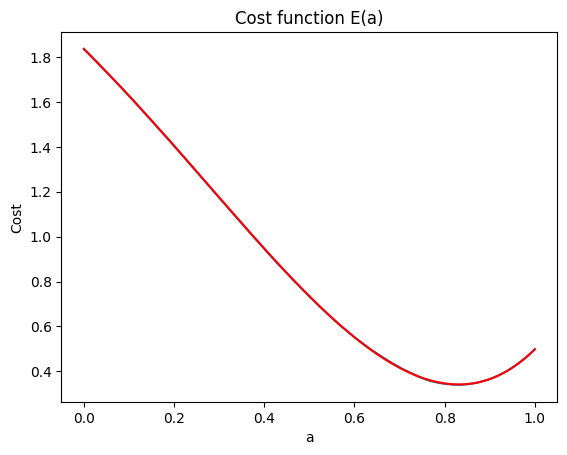

In [21]:
# Compute the cost for 1000 values of a
a_values = np.linspace(0, 1, 1000)
costs = [simulate_cost_vectorized(a) for a in a_values]
import matplotlib.pyplot as plt
plt.plot(a_values, costs)
plt.xlabel('a')
plt.ylabel('Cost')
plt.title('Cost function E(a)')

# Use polyfit to fit a 4th degree polynomial to the cost function
coefficients = np.polyfit(a_values, costs, 4)
poly = np.poly1d(coefficients)
# Plot the fitted polynomial
x_fit = np.linspace(0, 1, N)
y_fit = poly(x_fit)
plt.plot(x_fit, y_fit, label='Fitted polynomial', color='red')

# Show the polynomial coefficients
print("Fitted polynomial coefficients:", coefficients)

### Note that the graph is not smooth, so it makes sense that the binary search simulation does not converge within 10 decimal places. However, the fitted coefficients are close to our expected polynomial!